In [1]:
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import to_categorical

from deepcell.utils.plot_utils import create_rgb_image
from deepcell.datasets import SpotNetExampleData, SpotNet
from deepcell_spots.applications import SpotDetection
from deepcell_spots.dotnet_losses import DotNetLosses

from deepcell_spots.utils.augmentation_utils import subpixel_distance_transform

from deepcell_spots.image_generators import ImageFullyConvDotIterator

from function_bank import min_max_normalize, gaussian_filter, contrast_stretch

2024-11-07 13:57:49.478648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-07 13:57:49.478668: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/jonathanhp/Research/deepcell-spots-llm/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/jonathanhp/Research/deepcell-spots-llm/venv/lib64/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [2]:
spots_data = np.load('spot_data/SpotNet-v1_1/test.npz', allow_pickle=True)
spots_images = spots_data['X']
spots_truth = spots_data['y']

In [3]:
spots_image = spots_images
spots_truth = spots_truth
spots_image.shape

(94, 128, 128, 1)

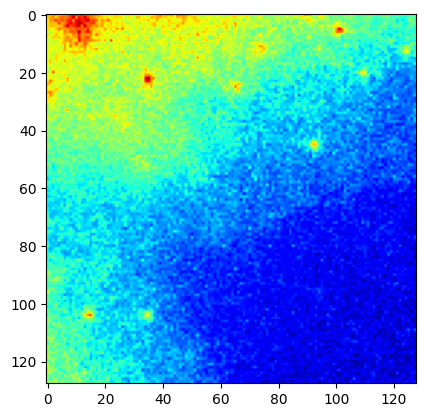

In [4]:
plt.imshow(spots_image[0].squeeze(), cmap='jet')

In [5]:
app = SpotDetection(preprocessing_fn=min_max_normalize)

INFO:root:Checking for cached data
INFO:root:Checking SpotDetection-8.tar.gz against provided file_hash...
INFO:root:SpotDetection-8.tar.gz with hash a6164e48ef8872a9524b4ec6726859d7 already available.
INFO:root:Extracting /home/jonathanhp/.deepcell/models/SpotDetection-8.tar.gz
INFO:root:Successfully extracted /home/jonathanhp/.deepcell/models/SpotDetection-8.tar.gz into /home/jonathanhp/.deepcell/models
2024-11-07 13:57:52.971479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jonathanhp/Research/deepcell-spots-llm/venv/lib/python3.9/site-packages/cv2/../../lib64:
2024-11-07 13:57:52.971504: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-07 13:57:52.971521: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on

In [6]:
pred, class_output, regress_output = app.predict(spots_image, batch_size=spots_images.shape[0], threshold=0.95)

pred.shape

2024-11-07 13:57:56.200809: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 788529152 exceeds 10% of free system memory.
2024-11-07 13:57:56.566163: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 788529152 exceeds 10% of free system memory.
2024-11-07 13:57:57.372127: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 788529152 exceeds 10% of free system memory.
2024-11-07 13:57:57.595362: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 794689536 exceeds 10% of free system memory.
2024-11-07 13:57:57.753298: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 950678400 exceeds 10% of free system memory.


(94,)

In [7]:
pred

array([array([[ 20.22990562, 109.15862015],
              [ 45.06952401,  92.12744646],
              [103.96025025,  14.15795052],
              [  5.36070853, 100.95171936],
              [ 12.6558497 , 124.07807033],
              [ 22.27909064,  34.80481122],
              [104.01621259,  34.72981369],
              [ 24.9213073 ,  65.3126232 ],
              [ 11.82942386,  73.87219043],
              [ 98.04709954,  22.76783152],
              [ 12.02543922,  93.94628574],
              [ 35.63461214,  15.31068796],
              [ 17.11904731,  99.73248541],
              [117.93840186,  49.04805663]]),
       array([[ 88.04147866,  92.04091903],
              [117.07330929,  92.92948003],
              [107.12245082,  39.2104616 ],
              [ 75.42577595,   9.12661682],
              [123.18749462,  64.06862439],
              [ 34.01868188,  33.11840519],
              [ 96.99645869,  73.23502544],
              [ 70.20256639,   7.8415035 ],
              [ 98.23653692,  

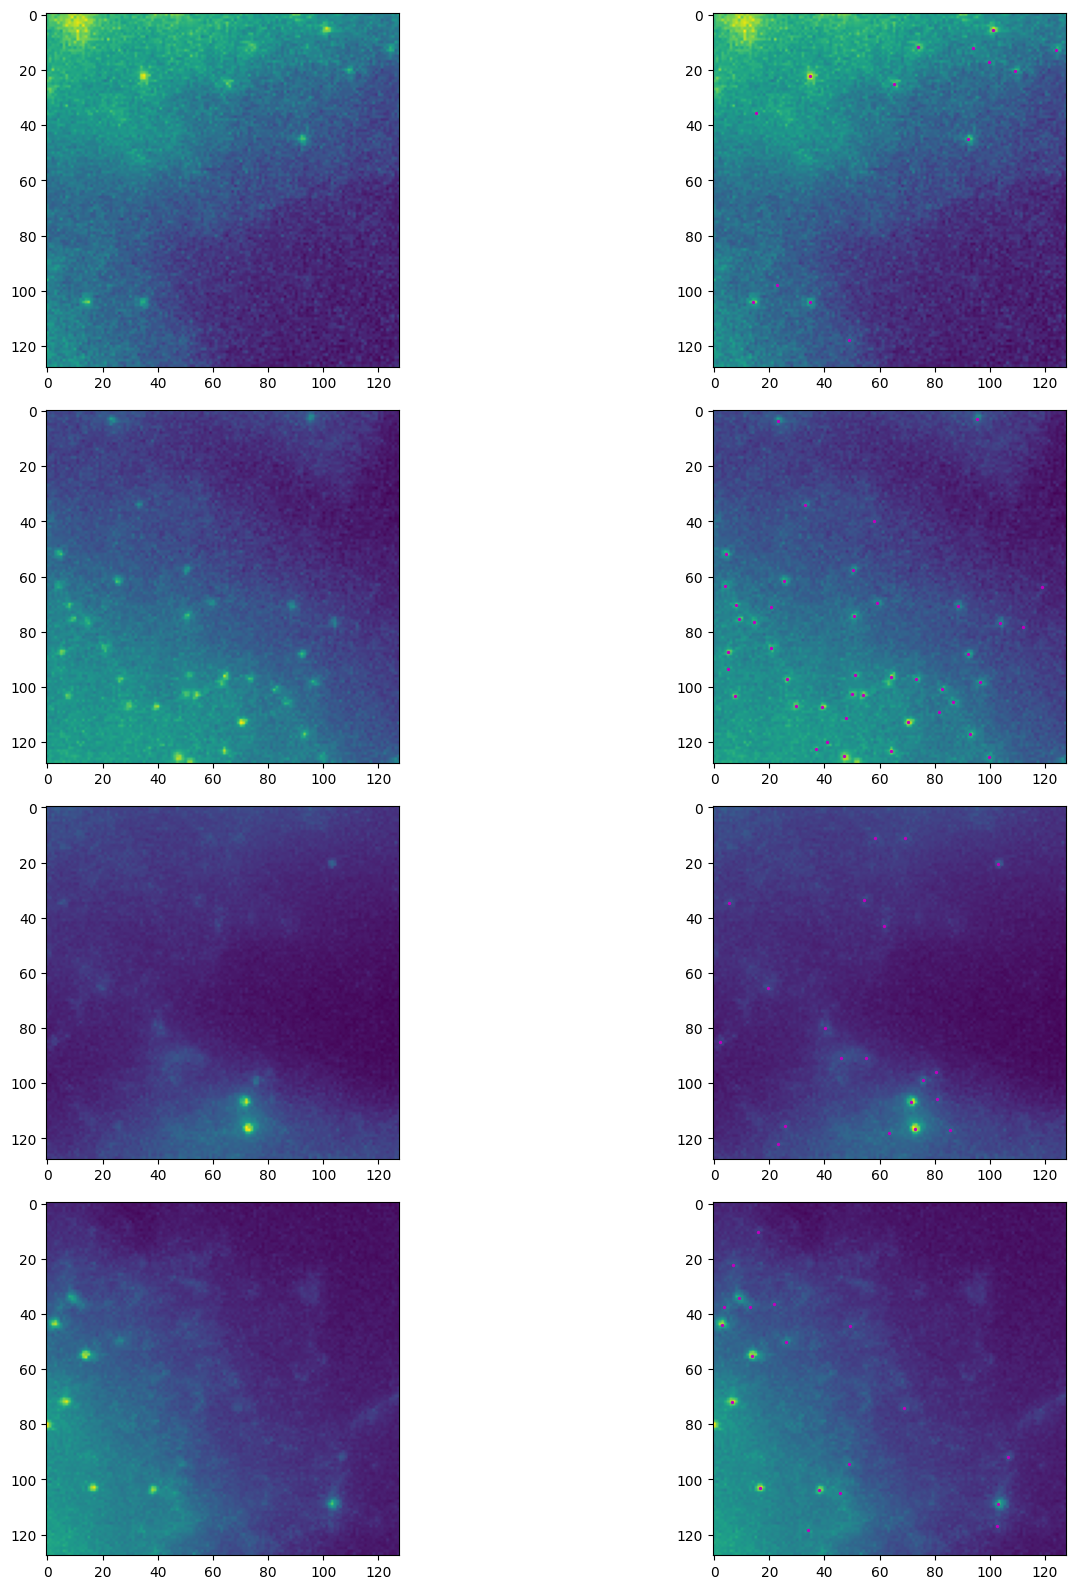

In [8]:
fig,ax = plt.subplots(4,2,figsize=(16,16))

for i in range(4):
    ax[i,0].imshow(spots_image[i,...,0], cmap='viridis')
    ax[i,1].imshow(spots_image[i,...,0], cmap='viridis')
    ax[i,1].scatter(pred[i][:,1], pred[i][:,0], c='m', s=2)


plt.tight_layout()
plt.show()

# Calculate losses

In [9]:
class_output.shape

(94, 128, 128, 2)

In [10]:
regress_output.shape

(94, 128, 128, 2)

In [11]:
def point_list_to_annotations(points, image_shape, dy=1, dx=1):
        """ Generate label images used in loss calculation from point labels.

        Args:
            points (np.array): array of size (N, 2) which contains points in the format [y, x].
            image_shape (tuple): shape of 2-dimensional image.
            dy: pixel y width.
            dx: pixel x width.

        Returns:
            annotations (dict): Dictionary with two keys, `detections` and `offset`.
                - `detections` is array of shape (image_shape,2) with pixels one hot encoding
                  spot locations.
                - `offset` is array of shape (image_shape,2) with pixel values equal to
                  signed distance to nearest spot in x- and y-directions.
        """

        contains_point = np.zeros(image_shape)
        for ind, [y, x] in enumerate(points):
            nearest_pixel_x_ind = int(round(x / dx))
            nearest_pixel_y_ind = int(round(y / dy))
            contains_point[nearest_pixel_y_ind, nearest_pixel_x_ind] = 1

        delta_y, delta_x, _ = subpixel_distance_transform(
            points, image_shape, dy=1, dx=1)
        offset = np.stack((delta_y, delta_x), axis=-1)

        one_hot_encoded_cp = to_categorical(contains_point)

        # TODO: refactor detections to classification
        annotations = {'detections': one_hot_encoded_cp, 'offset': offset}
        return annotations

In [12]:

losses = DotNetLosses()

sum_classification_loss = 0
sum_regression_loss = 0
for i in range(class_output.shape[0]):
    spot_annotations = point_list_to_annotations(spots_truth[i], spots_image.shape[1:3])
    sum_classification_loss += losses.classification_loss(spot_annotations['detections'], class_output[i]).numpy()
    sum_regression_loss += losses.regression_loss(spot_annotations['offset'], regress_output[i]).numpy()



In [13]:
sum_classification_loss / class_output.shape[0]

0.03751511862897809

In [14]:
sum_regression_loss / regress_output.shape[0]

0.31142117622050836